## Biostat 257 Homework 2

In [2]:
versioninfo()

Julia Version 1.7.2
Commit bf53498635 (2022-02-06 15:21 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin19.5.0)
  CPU: Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, skylake)


In [3]:
#load libraries
using BenchmarkTools, DelimitedFiles, Images, LinearAlgebra, Random

## Q1: Non-Negative Matrix Factorization

### Q1.1 Develop Code

#### Step 1: Develop Prototype of Function

In [20]:
function nnmf_prototype(
    X       :: Matrix{T}, 
    r       :: Integer;
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,
    V       :: Matrix{T} = rand(T, size(X, 1), r),
    W       :: Matrix{T} = rand(T, r, size(X, 2))
    ) where T <: AbstractFloat
    obj = norm(X - V * W)^2 # recording initial point of objective value
    # implementation
    niter = maxiter 
    # need to initialize or won't be able to find this var
    # set equal to maxiter because if convergence is never satisfied
    ## niter reported should be maxiter
    for iter in 1:maxiter
        # update V
        V .= V .* (X * W') ./ (V * W * W')
        # update W
        W .= W .* (V' * X) ./ (V' * V * W)
        # check convergence
        objold = obj # storing previous value of obj fcn
        obj = norm(X - V * W)^2 # refresh value of obj fcn with new V and W
        if abs(obj - objold) <= tolfun * (abs(objold) + 1) 
            # if this is satisfied we want to break out of the loop
            niter = iter # reporting iteration number
            break
        end
    end
    if niter == maxiter 
        @warn "maxiter reached without convergence"
    end
    # Output
    V, W, obj, niter
    
end

nnmf_prototype (generic function with 1 method)

#### Step 2: Optimize Code 

In [17]:
function nnmf(
    X       :: Matrix{T}, 
    r       :: Integer;
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,
    V       :: Matrix{T} = rand(T, size(X, 1), r),
    W       :: Matrix{T} = rand(T, r, size(X, 2))
    ) where T <: AbstractFloat
    
    n,m = size(X)
    
    # implementation
    
    niter = maxiter 
    
    # need to initialize or won't be able to find this var
    # set equal to maxiter because if convergence is never satisfied
    ## niter reported should be maxiter  
    
    # setting up intermediate storage of components of obj fcn
    
    storageR = Matrix{T}(undef, r, r)
    storageV1 = similar(V) 
    storageV2 = similar(V)
    storageW1 = similar(W)
    storageW2 = similar(W)
    storageX = similar(X)
    x2norm = norm(X)^2
    
    # initial objective
    
    obj = x2norm # recording initial point of obj value
    mul!(storageR, transpose(V), V)
    mul!(storageW2, storageR, W)
    mul!(storageW1, transpose(V), X)
    
    @inbounds for idx in eachindex(W)                           
            obj = obj + storageW2[idx] - 2storageW1[idx] * W[idx]   
    end
    
    for iter in 1:maxiter
        # update V = V .* (X * W') ./ (V * W * W')
        mul!(storageR, W, transpose(W)) # multiply W and W' and store result in storageR # O(nr^2)
        mul!(storageV2, V, storageR) 
        mul!(storageV1, X, transpose(W))
        V .= V .* storageV1 ./ storageV2
        # update W = W .* (V' * X) ./ (V' * V * W)
        mul!(storageR, transpose(V), V)
        mul!(storageW2, storageR, W)
        mul!(storageW1, transpose(V), X)
        objold = obj
        obj = x2norm
        @inbounds for idx in eachindex(W)                           # little confused about this part
            obj = obj + storageW2[idx] - 2storageW1[idx] * W[idx]   # trying to make computation of obj fcn more efficient
            W[idx] = W[idx] * storageW1[idx] / storageW2[idx]         # but how?
        end
        W .= W .* storageW1 ./ storageW2
        
        # check convergence
     
        if abs(obj - objold) <= tolfun * (abs(objold) + 1) 
            # if this is satisfied we want to break out of the loop
            niter = iter # reporting iteration number
            break
        end
    end
    if niter == maxiter 
        @warn "maxiter reached without convergence"
    end
    # Output
    V, W, obj, niter
    
end

nnmf (generic function with 1 method)

#### Q1.2 Data

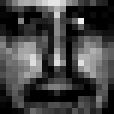

In [6]:
X = readdlm("nnmf-2429-by-361-face.txt") # each row is a face, goal: low rank approx of a face
colorview(Gray, reshape(X[1, :], 19, 19))

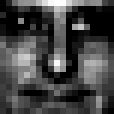

In [7]:
colorview(Gray, reshape(X[5, :], 19, 19))

#### Q1.3 Correctness and Efficiency

In [15]:
V0full = readdlm("V0.txt")
W0full = readdlm("W0.txt")

50×361 Matrix{Float64}:
 0.5634    0.32048   0.067202   0.25107   …  0.4476     0.12656   0.13688
 0.71473   0.25423   0.084735   0.84327      0.20947    0.32729   0.43787
 0.046351  0.041688  0.79152    0.8962       0.6786     0.17112   0.83691
 0.76991   0.13366   0.0061026  0.70588      0.4457     0.012722  0.64244
 0.56335   0.35408   0.62697    0.94923      0.073816   0.62934   0.58596
 0.13659   0.82449   0.17183    0.051802  …  0.87725    0.86247   0.45418
 0.2326    0.92296   0.73855    0.35246      0.015108   0.68424   0.15457
 0.95628   0.97221   0.94922    0.59106      0.49038    0.52232   0.4399
 0.82876   0.33257   0.95808    0.11028      0.66812    0.69979   0.57679
 0.33585   0.59454   0.75948    0.26544      0.34689    0.071471  0.020196
 0.87571   0.83349   0.83207    0.57283   …  0.34609    0.22545   0.2295
 0.27631   0.10171   0.4809     0.10614      0.0039955  0.92647   0.27393
 0.914     0.45783   0.32193    0.65607      0.1204     0.29447   0.88988
 ⋮             

In [21]:
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    @time V, W, obj, niter = nnmf(X, r; V = V0, W = W0)
    println("obj=$obj, niter=$niter")
end

r=10
  0.219170 seconds (24 allocations: 7.117 MiB)
obj=-73013.63901894419, niter=81
r=20
  0.530117 seconds (24 allocations: 7.545 MiB)
obj=-84053.74316517542, niter=133
r=30
  0.435461 seconds (24 allocations: 7.975 MiB)
obj=-87823.92420246308, niter=111
r=40
  0.300912 seconds (24 allocations: 8.406 MiB)
obj=-89040.93324370055, niter=71
r=50
  0.468738 seconds (25 allocations: 8.839 MiB)
obj=-92051.40303868835, niter=91


### Q2: Estimating Kinship Matrix

#### Q2.1 Develop code

In [ ]:
function kinship(G::Matrix{T}) where T <: AbstractFloat
    n, m = size(G)
    Φ = zeros(n, m)
    # output
    Φ
end